# 1. Data Cleaning

In [97]:
# Imports
import os
import re
import copy
import numpy as np
import pdfplumber
import pandas as pd
import nltk
import openai
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.metrics.pairwise import cosine_similarity

In [63]:
pdf_dir = "./data"
pdf_files = [f for f in os.listdir(pdf_dir) if f.endswith(".pdf")]
title_abstract_list = []

In [64]:
def extract_title_abstract(pdf_path):
    with pdfplumber.open(pdf_path) as pdf:
        page = pdf.pages[0]

        text = page.extract_text(x_tolerance=1, y_tolerance=5)

        # print(page.chars)
        table={}
        for x,i in enumerate(page.chars):
            # print(i["text"])
            # if i["text"]==" " or i["text"]=="\n":
            #     print("new line")
            if i["size"] not in table:
                table[i["size"]]=""
            if x>0 and i["x0"]-page.chars[x-1]["x1"]>=1:
                table[i["size"]]+=" "
            if x>0 and page.chars[x-1]["y1"]-i["y1"]>5:
                table[i["size"]]+=" "
            table[i["size"]]+=i["text"]


        # print(text,"\n") 
        tmp=copy.deepcopy(table)

        for i in tmp:
            if len(tmp[i])<30:
                del table[i]

        title=table[max(table.keys())].strip().replace("  "," ")
        abstract_match = re.search(r"Abstract\s+(.*?[.!?])\s*\n[c,©]", text, re.DOTALL)
        if not abstract_match:
            abstract_match = re.search(r'(?i)abstract\b\.?:?]?\s+((?:.|\n)+?)(?=\n\d+\.|Key|Introduction|[0,1]?\Z)', text, re.DOTALL)

        if abstract_match:
            abstract = abstract_match.group(1).strip()

    if not abstract_match:
        abstract = "No abstract found"
    # abstract = text.split('\n')
    # print("Title: ",title,"Abstract: ",abstract)
    # print(title, "\n")

    return title, abstract

In [65]:
def get_text_from_pdf(pdf_path):
    allText=""
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
             allText+=page.extract_text(x_tolerance=1, y_tolerance=5)
    return allText

lemmatizer=WordNetLemmatizer()


def preprocess_text(text):
    words=word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered= [lemmatizer.lemmatize(w.lower()) for w in words if not w in stop_words and w.isalpha()]
    return filtered


# 2. Embeddings

In [99]:
load_dotenv()
openai.api_key = os.getenv("KEY")

In [66]:
embeddings={}

def get_embedding(text, model="text-embedding-ada-002"):
   return openai.Embedding.create(input = text, model=model)['data'][0]['embedding']

for i in pdf_files:
    text=get_text_from_pdf("./data/"+i)
    filtered=" ".join(preprocess_text(text))
    if len(filtered)>8192:
        filtered=filtered[:8192]
    embeddings[i]=get_embedding(filtered)

    

In [94]:
import random

random_indices = random.sample(range(len(pdf_files)), 5)
random_indices

[4, 23, 18, 2, 30]

In [68]:
random_embeddings = np.array([embeddings[pdf_files[i]] for i in random_indices])
random_documents = [pdf_files[i] for i in random_indices]

In [69]:
for i,j in zip(random_documents,random_embeddings):
    print('Most similar documents to Document', i, 'are:')
    table={}
    for k,l in embeddings.items():
        if k!=i:
            j=np.array(j).reshape(1,-1)
            l=np.array(l).reshape(1,-1)
            table[k]=cosine_similarity(j,l)
    table=sorted(table.items(), key=lambda x: x[1], reverse=True)
    for k in table[:3]:
        print("Document:",k[0],"Similarity:",k[1][0][0])


Most similar documents to Document doc24.pdf are:
Document: doc4.pdf Similarity: 0.9078691284787852
Document: doc1.pdf Similarity: 0.8965109508918251
Document: doc21.pdf Similarity: 0.8877425636816906
Most similar documents to Document doc2.pdf are:
Document: doc1.pdf Similarity: 0.9170850919359064
Document: doc28.pdf Similarity: 0.9075088646608152
Document: doc30.pdf Similarity: 0.8940143192454767
Most similar documents to Document doc21.pdf are:
Document: doc17.pdf Similarity: 0.9022560729319388
Document: doc10.pdf Similarity: 0.8960892811838692
Document: doc29.pdf Similarity: 0.8897040568765139
Most similar documents to Document doc17.pdf are:
Document: doc14.pdf Similarity: 0.9069426843939624
Document: doc27.pdf Similarity: 0.903119032598409
Document: doc21.pdf Similarity: 0.9022560729319388
Most similar documents to Document doc23.pdf are:
Document: doc22.pdf Similarity: 0.9317419400565824
Document: doc20.pdf Similarity: 0.9194163832257395
Document: doc7.pdf Similarity: 0.91429724

Using Doc2Vec for Document Similarity

In [88]:
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from gensim.models.doc2vec import Doc2Vec

In [89]:
docsSorted = sorted(pdf_files, key=lambda x: (int(x.split('doc')[1].split('.pdf')[0])))

dataD2V = []

for i in docsSorted:
    text=get_text_from_pdf("./data/"+i)
    dataD2V.append(" ".join(preprocess_text(text)))

dataD2VTagged = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(dataD2V)]

In [90]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=30, min_count=2, epochs=80)
model.build_vocab(dataD2VTagged)
model.train(dataD2VTagged, total_examples=model.corpus_count, epochs=80)
model.save("DocsSimilarity.model")
model = Doc2Vec.load("DocsSimilarity.model")

In [104]:
docNum = 29  # Place a number to see which you want
similar_doc = model.dv.most_similar(str(docNum), topn=3)
print("Selected Document", docsSorted[docNum-1])
print("Array Featuring Three Most Similar Docs", similar_doc)
print("Names of Three Most Similar Documents:", docsSorted[int(similar_doc[0][0])-1] + "  " +
      docsSorted[int(similar_doc[1][0])-1] + "  " + docsSorted[int(similar_doc[2][0])-1])

Selected Document doc29.pdf
Array Featuring Three Most Similar Docs [('28', 0.5703748464584351), ('26', 0.36563578248023987), ('5', 0.3308534026145935)]
Names of Three Most Similar Documents: doc28.pdf  doc26.pdf  doc5.pdf


# 3. Dimensionality Reduction

In [ ]:
df=pd.DataFrame(embeddings.items(),columns=["file","embedding"])
df

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

matrix=np.array(list(embeddings.values()))
scaled=StandardScaler().fit_transform(matrix)


pca=PCA(n_components=2)

reduced=pca.fit_transform(scaled)
df["reduced2D"]=reduced.tolist()

pca=PCA(n_components=30)

reduced30=pca.fit_transform(scaled)
df["reduced30D"]=reduced30.tolist()

# 4. Clustering

/home/verse/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/verse/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/verse/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/verse/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1

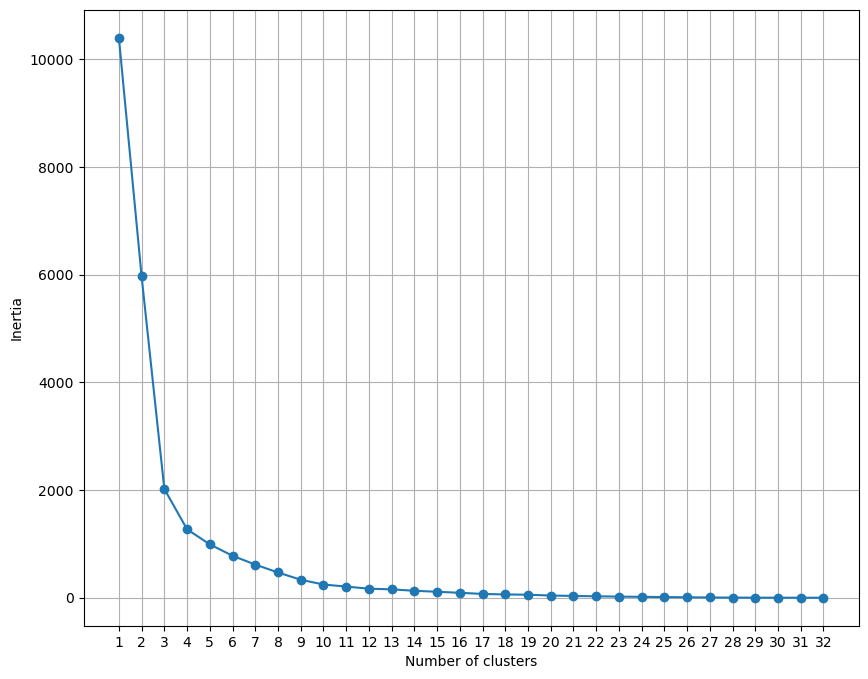

In [38]:
from sklearn.cluster import KMeans
intertia=[]


for i in range(1,33):
    KM=KMeans(n_clusters=i).fit(df['reduced2D'].tolist())
    intertia.append(KM.inertia_)

plt.figure(figsize=(10,8))
plt.plot(range(1,33),intertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(range(1,33))
plt.grid(True)
plt.show()

In [39]:
clustering=KMeans(n_clusters=4).fit(df["reduced30D"].tolist())
centroids = clustering.cluster_centers_
df["cluster"]=clustering.labels_
df

/home/verse/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,file,embedding,reduced2D,reduced30D,cluster
0,doc1.pdf,"[-0.010899050161242485, 0.009243933483958244, ...","[12.24305290868822, 2.429277599270635]","[12.243043735759013, 2.4303799355555302, 6.130...",2
1,doc10.pdf,"[-0.011495056562125683, 0.007070209365338087, ...","[-16.096384983781657, -16.201633165208957]","[-16.096445323803348, -16.20208193437844, 4.02...",1
2,doc11.pdf,"[-0.023077594116330147, 0.011173906736075878, ...","[-13.769842185739394, -13.549527790596956]","[-13.769810621299975, -13.549451732113821, -10...",3
3,doc12.pdf,"[-0.016462575644254684, 0.006374605931341648, ...","[-16.275740338974177, -15.848396039144188]","[-16.2758232672909, -15.849625352184045, 8.869...",1
4,doc13.pdf,"[-0.0025639308150857687, 0.02657500095665455, ...","[-2.929961546074686, -19.63637492415347]","[-2.9298990838041497, -19.63592693223456, -16....",1
5,doc14.pdf,"[-0.02178957872092724, 0.013681197538971901, -...","[-6.180354618928428, -8.510821030809593]","[-6.1803510880187735, -8.51274015924645, 3.468...",1
6,doc15.pdf,"[-0.018582995980978012, -0.001294617773965001,...","[-15.019978399742095, -13.295045064405947]","[-15.019968329451727, -13.294524567701416, 8.8...",3
7,doc16.pdf,"[-0.010200449265539646, 0.0008296011365018785,...","[-15.766907197226152, -14.373267064910445]","[-15.766899395154603, -14.37337330474064, 2.46...",3
8,doc17.pdf,"[-0.028320131823420525, -0.0018204357475042343...","[-13.765425025936212, 0.37522413444948977]","[-13.765371384942139, 0.37534131767055506, 5.4...",1
9,doc18.pdf,"[-0.026384860277175903, 0.018750730901956558, ...","[-0.12296249791370928, -0.9843896339441146]","[-0.12296633629168781, -0.9831807571522979, -1...",2


In [59]:
from scipy.spatial import distance
cluster_info = pd.DataFrame(columns=['Cluster number', 'Representative documents'])
clustered={}
for i, centroid in enumerate(centroids):
    distances = distance.cdist([centroid], df['reduced30D'].tolist(), 'euclidean')[0]
    closest_indices = distances.argsort()
    representatives = []
    count=0
    j=0
    while(count!=3 and j!=len(closest_indices)):
        if df.iloc[closest_indices[j]]['cluster']==i:
            title, abstract = extract_title_abstract("./data/"+df['file'][closest_indices[j]])
            representatives.append(df['file'][closest_indices[j]]+" | "+title + " | " + abstract)
            representative_docs = "\n".join(representatives)
            count+=1
        j+=1
    cluster_info = cluster_info.append({'Cluster number': i, 'Representative documents': representative_docs}, ignore_index=True)
    
cluster_info.to_csv('cluster_info.csv', index=False)

In [55]:
x = [p[0] for p in df['reduced2D']]
y = [p[1] for p in df['reduced2D']]

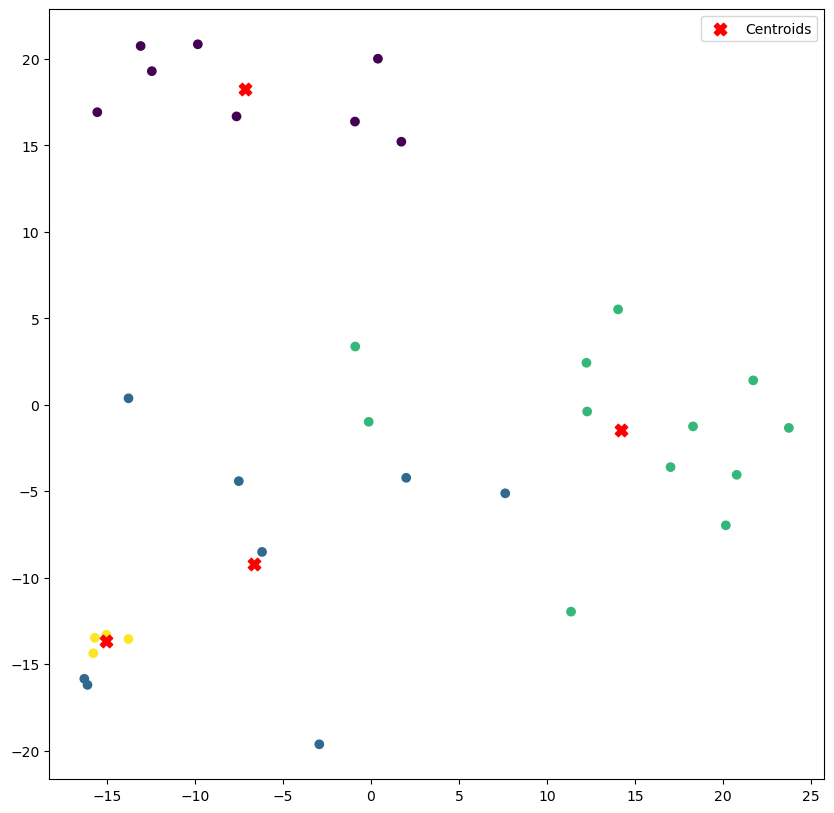

In [56]:
plt.figure(figsize=(10,10))
plt.scatter(x, y, c=clustering.labels_)
plt.scatter(centroids[:, 0], centroids[:, 1], color='red', marker='X', s=80, label='Centroids')
plt.legend()
plt.show()

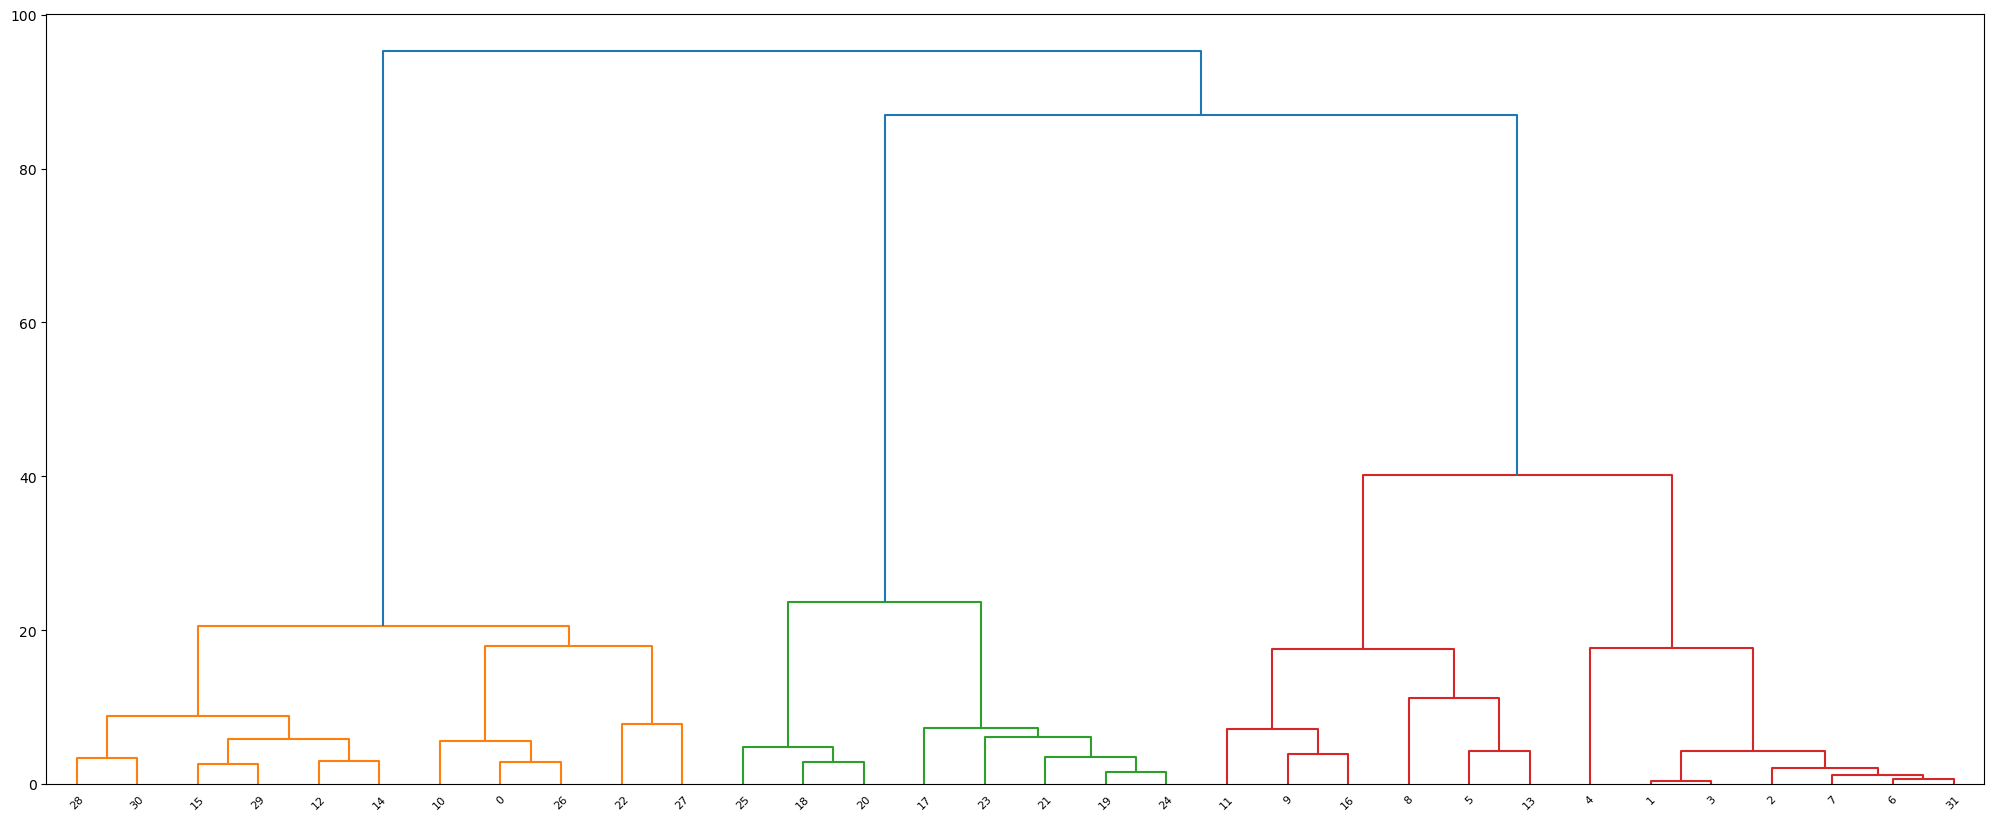

In [45]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(reduced, method='ward') 

plt.figure(figsize=(25, 10))
dendrogram(Z)
plt.show()

# 5. Class-based TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

class ClassBasedTFIDF:
    def __init__(self, documents, clusters):
        self.docs = documents
        self.clsts = clusters
        self.clstDocs = self.docsMergeByClst()
        self.tfIdfMat, self.feature_names = self.tfIdf()
        self.topWords = self.getTopKeys()

    def docsMergeByClst(self):
        clstDocs = {}
        for doc, clst in zip(self.documents, self.clusters):
            if clst not in clstDocs:
                clstDocs[clst] = ""
            clstDocs[clst] += " " + doc
        return clstDocs

    def tfIdf(self):
        vectorizer = TfidfVectorizer()
        docs = [doc for doc in self.clstDocs.values()]
        tfIdfMat = vectorizer.fit_transform(docs)
        featNames = vectorizer.get_feature_names_out()
        return tfIdfMat, featNames

    def getTopKeys(self, top_n=6):
        topWords = {}
        for clst, doc in self.clstDocs.items():
            row = self.clsts.index(clst)
            scores = np.array(self.tfIdfMat[row].todense()).flatten()
            sorted_indices = np.argsort(scores)[::-1][:top_n]
            keywords = [self.feature_names[index] for index in sorted_indices]
            topWords[clst] = keywords
        return topWords

    def csvAdd(self, fName='cluster_info.csv'):
        data = []
        for clst, keywords in self.topWords.items():
            repDocChars = self.clstDocs[clst][:100]  # Assuming you want the first 100 chars as representative
            data.append([clst, repDocChars, ", ".join(keywords)])
        df = pd.DataFrame(data, columns=['Cluster number', 'Representative documents', 'Top keywords'])
        df.to_csv(fName, index=False)

In [ ]:
# Sample usage
documents = ["doc1 text here", "doc2 text here", ...]  # List of all documents
clusters = [0, 1, ...]  # Cluster index for each document
tfidf_obj = ClassBasedTFIDF(documents, clusters)
tfidf_obj.append_to_csv()

# 6. Improve topic representations

In [ ]:
am i supposed to straight up use chatgpt....


Oh you meant for part 6... hmm, lemme read the thingy one sec
yes pls

yea I'd assume so... you'd just bring in the API to VS code and ask it to print out prompts based on top keywords?

what does that even mean lmaooo

so basically we're asking ChatGPT to generate a topic based on the top keywords of certain clusters and the documents within. 

For example, if 5 documents revolve around the politics of soccer in 2016, then it would create the topic representation based
off of 'soccer' 'Benzema'"7kooma''red card...' shit like that

one sec lemme go through the api

kk

